In [5]:
import sys
import pathlib
import numpy as np
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0, "../utils/")
from data_loader import load_data, load_train_test_data

In [6]:
# data path
data_directory = "../0.data-download/data/"

In [7]:
# load the training data
train_data = load_train_test_data(
    data_directory, train_or_test="train", load_gene_stats=False, drop_columns=False
)

In [8]:
# set a unique dataframe that can be appended from
training_df_age = train_data

# group by age and create new dataframes that can be appended to
groups = training_df_age.groupby("age_and_sex")
adult_effect_df = pd.DataFrame()
ped_effect_df = pd.DataFrame()
for name, training_df_age in groups:

    # append rows that contain Adult samples (male or female) to the new adult effect dataframe
    if name == "Adult_Male" or name == "Adult_Female" or name == "Adult_nan":
        adult_effect_df = adult_effect_df._append(training_df_age)
        adult_effect_df = adult_effect_df.reset_index(drop=True)

    # append rows that contain Pediatric samples (male ore female) to the new pediatric dataframe
    else:
        ped_effect_df = ped_effect_df._append(training_df_age)
        ped_effect_df = ped_effect_df.reset_index(drop=True)

In [9]:
# set a unique dataframe that can be appended from
training_df_sex = train_data

# group by sex and create new dataframes to be appended to
groups_sex = training_df_sex.groupby("age_and_sex")
male_effect_df = pd.DataFrame()
female_effect_df = pd.DataFrame()
for name, training_df_sex in groups_sex:

    # append rows that contain Male samples (Adult or Pediatric) to the new male effect dataframe and filter out samples that contain no gender info
    if (
        name == "Adult_Male"
        or name == "Pediatric_Male"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        male_effect_df = male_effect_df._append(training_df_sex)
        male_effect_df = male_effect_df.reset_index(drop=True)

    # append rows that contain Female samples (Adult or Pediatric) to the new female effect dataframe and filter out samples that contain no gender info
    elif (
        name == "Adult_Female"
        or name == "Pediatric_Female"
        and name != "Pediatric_nan"
        and name != "Adult_nan"
    ):
        female_effect_df = female_effect_df._append(training_df_sex)
        female_effect_df = female_effect_df.reset_index(drop=True)

In [10]:
print(adult_effect_df.shape)
adult_effect_df.head(3)

(569, 17109)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000325,-0.074936,-0.136946,0.138422,0.160257,-0.085101,-0.106547,-0.224571,0.102947,-0.017080,...,-0.870535,0.038346,0.278312,-0.102113,-0.048972,-0.256376,0.127786,-0.118434,-0.181762,Adult_Female
1,ACH-001517,0.008398,-0.220268,0.134104,0.123550,-0.130890,-0.112240,-0.041265,-0.097503,0.281660,...,-0.375564,0.076904,0.071104,-0.005431,-0.116168,-0.146180,-0.112175,-0.163010,-0.113963,Adult_Female
2,ACH-001521,-0.087441,-0.131241,-0.000071,0.227819,-0.164042,0.072007,-0.006590,-0.118601,0.282064,...,-0.259317,-0.038643,0.012085,0.361920,0.135756,-0.124951,0.252163,-0.333798,-0.056990,Adult_Female


In [11]:
print(ped_effect_df.shape)
ped_effect_df.head(3)

(101, 17109)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-001618,-0.060817,-0.280227,-0.029631,-0.117757,-0.066095,0.033039,0.367531,0.191806,-0.119773,...,-0.079149,-0.112526,-0.063046,-0.076179,0.096559,-0.406814,-0.168632,-0.261766,0.003597,Adult_Unknown
1,ACH-001211,-0.086857,-0.080244,0.124842,0.114957,-0.127217,-0.166439,-0.055770,-0.299170,-0.038803,...,-0.364302,-0.091124,-0.242115,-0.079042,0.087544,-0.254418,-0.213908,-0.169750,0.038995,Pediatric_Female
2,ACH-001300,-0.210638,0.075649,0.075370,-0.033036,-0.340549,-0.229177,-0.048669,-0.188698,-0.147961,...,-0.486237,-0.031050,0.193135,-0.337853,-0.035557,-0.274687,0.158534,-0.217785,-0.240230,Pediatric_Female


In [12]:
print(male_effect_df.shape)
male_effect_df.head(3)

(378, 17109)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000748,0.012028,-0.006677,0.036935,0.121707,0.016289,-0.025442,-0.052198,-0.096108,-0.044065,...,0.024700,0.058618,0.074532,-0.004903,-0.015067,-0.193579,-0.006900,-0.223866,-0.531785,Adult_Male
1,ACH-000645,-0.039652,0.012859,0.098430,0.211424,0.071939,-0.041163,0.064852,0.104537,-0.210986,...,-1.326112,-0.085177,-0.096491,-0.148075,-0.021919,-0.095724,-0.227744,-0.074700,-0.322054,Adult_Male
2,ACH-000361,-0.012368,-0.246941,-0.180033,0.066758,-0.122263,-0.016613,-0.084617,-0.286977,-0.110304,...,-0.456687,-0.096536,-0.187451,-0.037712,0.105396,-0.342785,-0.031349,-0.083826,-0.447043,Adult_Male


In [13]:
print(female_effect_df.shape)
female_effect_df.head(3)

(285, 17109)


,ModelID,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),...,ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009),age_and_sex
0,ACH-000325,-0.074936,-0.136946,0.138422,0.160257,-0.085101,-0.106547,-0.224571,0.102947,-0.017080,...,-0.870535,0.038346,0.278312,-0.102113,-0.048972,-0.256376,0.127786,-0.118434,-0.181762,Adult_Female
1,ACH-001517,0.008398,-0.220268,0.134104,0.123550,-0.130890,-0.112240,-0.041265,-0.097503,0.281660,...,-0.375564,0.076904,0.071104,-0.005431,-0.116168,-0.146180,-0.112175,-0.163010,-0.113963,Adult_Female
2,ACH-001521,-0.087441,-0.131241,-0.000071,0.227819,-0.164042,0.072007,-0.006590,-0.118601,0.282064,...,-0.259317,-0.038643,0.012085,0.361920,0.135756,-0.124951,0.252163,-0.333798,-0.056990,Adult_Female


In [14]:
# drop the string values from all dataframes
adult_effect_df_float = adult_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)
ped_effect_df_float = ped_effect_df.drop(columns=["ModelID", "age_and_sex"])

male_effect_df_float = male_effect_df.drop(columns=["ModelID", "age_and_sex"])
female_effect_df_float = female_effect_df.drop(
    columns=["ModelID", "age_and_sex"]
)

effect_df = train_data.drop(columns="age_and_sex")
effect_df = effect_df.set_index("ModelID")

In [15]:
# t_test comparing gene dependencies in adult vs pediatric samples
t_test = ttest_ind(adult_effect_df_float, ped_effect_df_float)
t_test = pd.DataFrame(t_test).T
t_test.columns = ["t_stat", "p_value"]
print(t_test.shape)
t_test.head(3)

(17107, 2)


,t_stat,p_value
0,1.644153,0.100615
1,-1.434572,0.151877
2,-0.505060,0.613683


In [16]:
# t_test comparing gene dependencies in male vs female samples
t_test_sex = ttest_ind(male_effect_df_float, female_effect_df_float)
t_test_sex = pd.DataFrame(t_test_sex).T
t_test_sex.columns = ["t_stat", "p_value"]
print(t_test_sex.shape)
t_test_sex.head(3)

(17107, 2)


,t_stat,p_value
0,0.051280,0.959118
1,1.037612,0.299830
2,1.257953,0.208853


In [17]:
print(effect_df.shape)
effect_df.head(3)

(670, 17107)


,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZWILCH (55055),ZWINT (11130),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
ModelID,,,,,,,,,,,,,,,,,,,,,
ACH-000748,0.012028,-0.006677,0.036935,0.121707,0.016289,-0.025442,-0.052198,-0.096108,-0.044065,0.096509,...,-0.195605,0.024700,0.058618,0.074532,-0.004903,-0.015067,-0.193579,-0.006900,-0.223866,-0.531785
ACH-000645,-0.039652,0.012859,0.098430,0.211424,0.071939,-0.041163,0.064852,0.104537,-0.210986,0.301049,...,-0.286172,-1.326112,-0.085177,-0.096491,-0.148075,-0.021919,-0.095724,-0.227744,-0.074700,-0.322054
ACH-001301,-0.014705,-0.000141,0.110479,-0.034653,0.038232,-0.158461,-0.097903,-0.115773,0.119688,0.211578,...,-0.490207,-0.502931,0.398217,0.238408,0.007151,0.091789,-0.489645,-0.033089,-0.210309,-0.135954


In [18]:
# calculate variance of each gene then send the results plus the gene info into a new dataframe
variance = effect_df.var()
variance_list = variance.tolist()
column_names = ["variance"]
variance_df = pd.DataFrame(variance, columns=column_names)
variance_df = variance_df.sort_index(ascending=True).reset_index()
variance_df = variance_df.rename(columns={"index": "gene_ID"})
print(variance_df.shape)
variance_df.head(3)

(17107, 2)


,gene_ID,variance
0,A1BG (1),0.010877
1,A1CF (29974),0.011863
2,A2M (2),0.010105


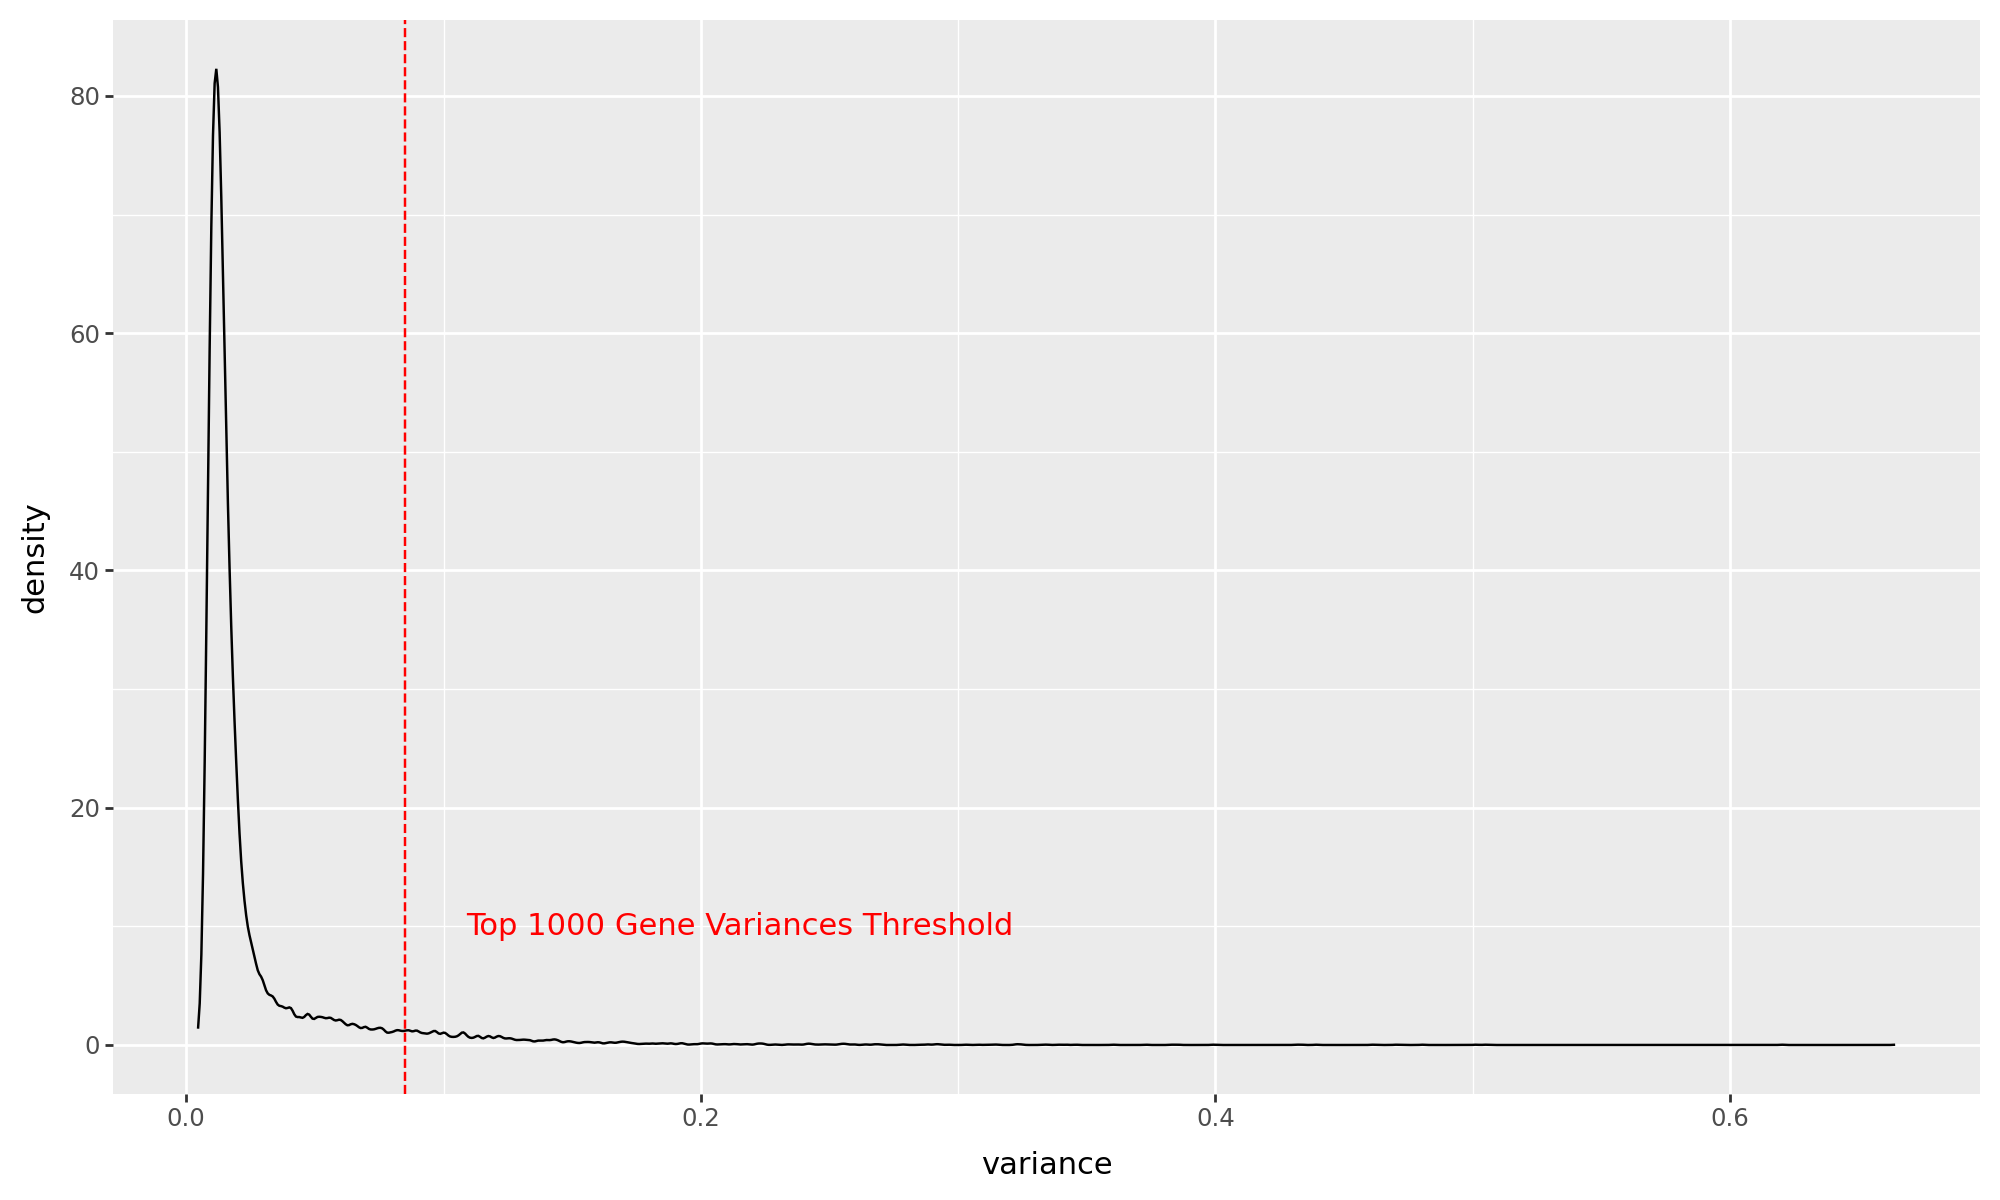

In [19]:
# finding the smallest gene variation out of the 1000 largest gene variations to set the top 1000 gene variances threshold
n = variance_df["variance"].nlargest(1000)
variance_threshold = n.astype(float).min()

# plotting variance density chart and marking the 1000 largest gene variation cutoff
variance_density_plot = (
    p9.ggplot(variance_df, p9.aes(x="variance"))
    + p9.geom_density()
    + p9.geom_vline(xintercept=variance_threshold, linetype="dashed", color="red")
    + p9.annotate(geom="text", x=variance_threshold + 0.13, y = 10, label="Top 1000 Gene Variances Threshold", color="red") 
    + p9.theme(figure_size=(10, 6))
)

# save the figure
density_path = pathlib.Path("./figures/variance_density_plot.png")
variance_density_plot.save(density_path)
variance_density_plot

In [20]:
# first create new dataframe containing gene info as well as both adult-pediatric and male-female t-test results and variance results
df = variance_df.assign(
    ttest_A_vs_P=t_test.t_stat.astype(float),
    ttest_M_vs_F=t_test_sex.t_stat.astype(float),
)

# and save the new dataframe as a .parquet
testing_df_output = pathlib.Path(
    "../0.data-download/data/genes_variances_and_t-tests_df.parquet"
)
df.to_parquet(testing_df_output, index=False)
print(df.shape)
df.head(3)

(17107, 4)


,gene_ID,variance,ttest_A_vs_P,ttest_M_vs_F
0,A1BG (1),0.010877,1.644153,0.051280
1,A1CF (29974),0.011863,-1.434572,1.037612
2,A2M (2),0.010105,-0.505060,1.257953


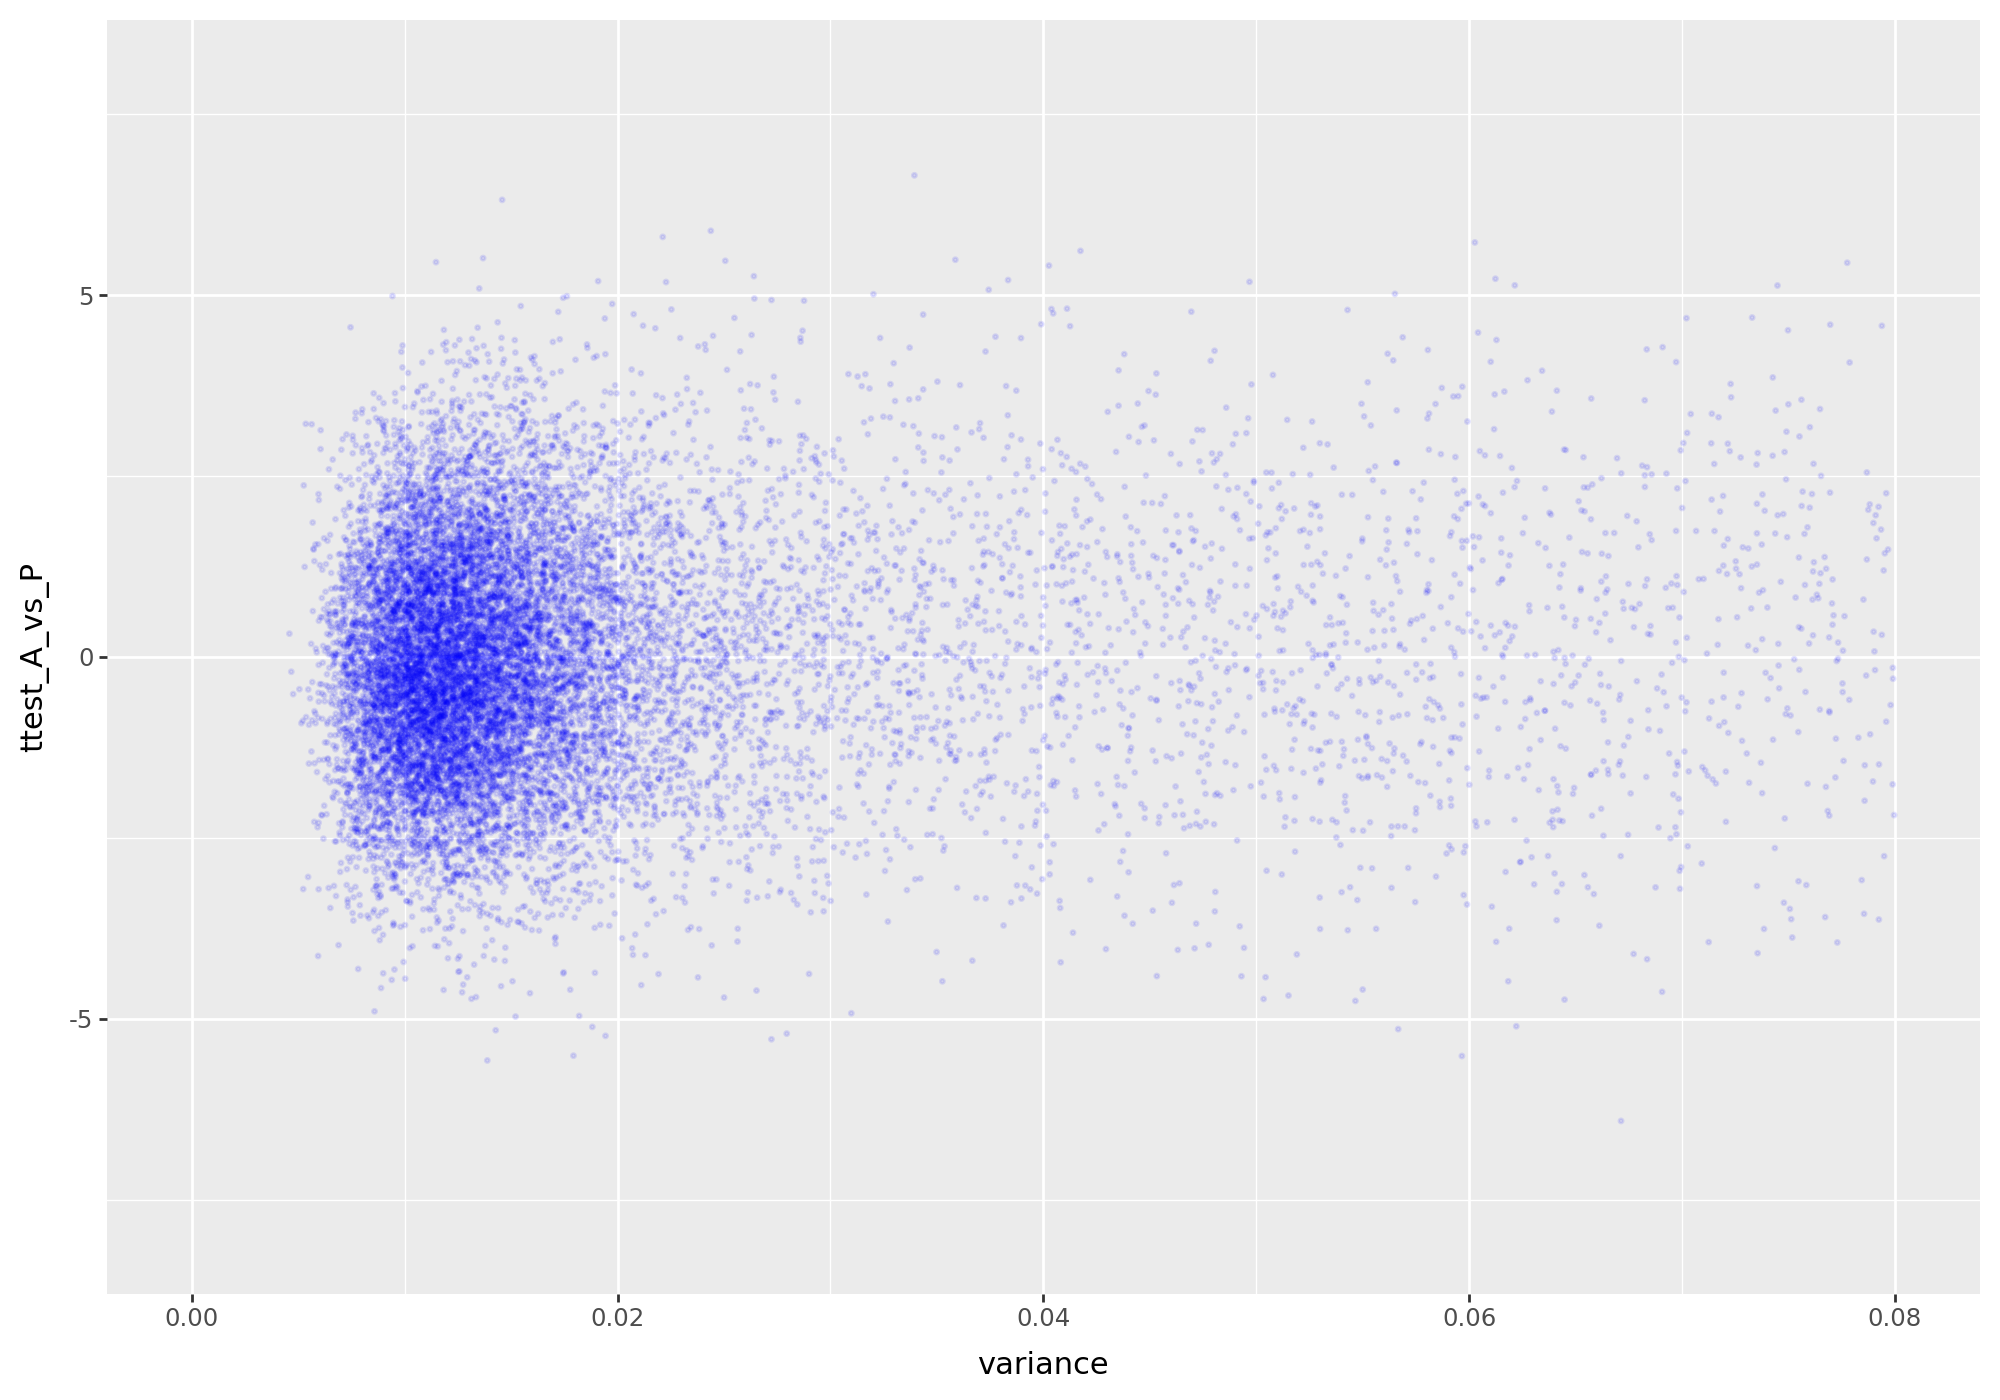

In [21]:
# plot adult-pediatric ttest versus variance
A_vs_P_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_A_vs_P"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
    + p9.xlim(0.00, 0.08)
    + p9.ylim(-8,8)
)

# save the figure
adult_vs_pediatric_path = pathlib.Path(
    "./figures/adult-pediatric_ttest_vs_variance.png"
)
A_vs_P_by_variance_plot.save(adult_vs_pediatric_path)
A_vs_P_by_variance_plot

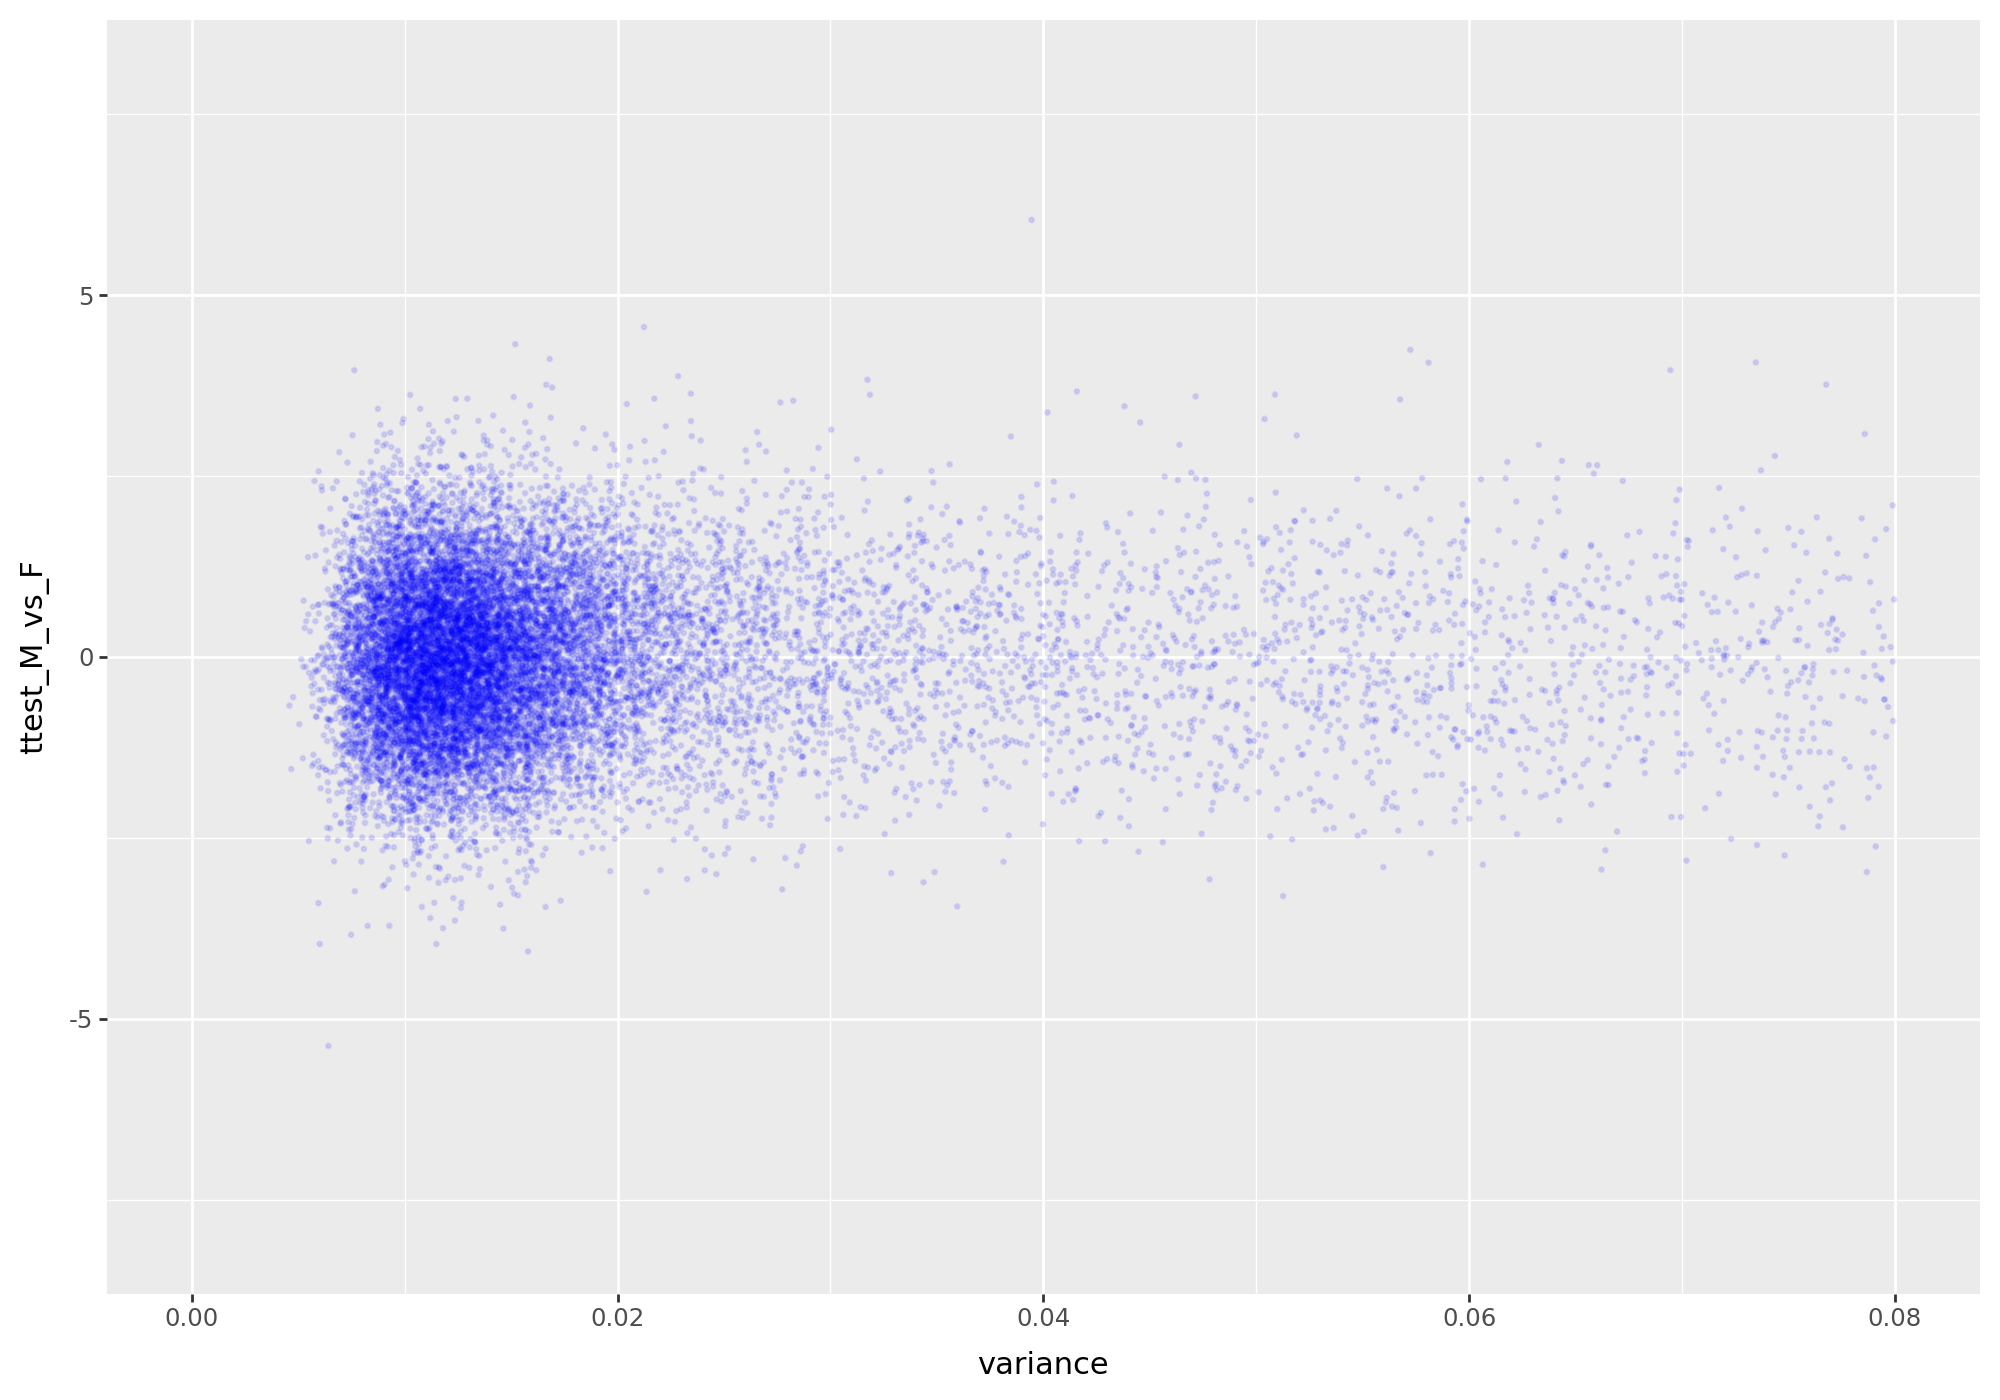

In [22]:
# plot male-female ttest versus gene variance
M_vs_F_by_variance_plot = (
    p9.ggplot(data=df, mapping=p9.aes(x="variance", y="ttest_M_vs_F"))
    + p9.geom_point(size=0.4, alpha=0.1, color="blue")
    + p9.theme(figure_size=(10, 7))
    + p9.xlim(0.00, 0.08)
    + p9.ylim(-8,8)
)

# save the figure
male_vs_female_path = pathlib.Path("./figures/male-female_ttest_vs_variance.png")
M_vs_F_by_variance_plot.save(male_vs_female_path)
M_vs_F_by_variance_plot